In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recommendation-engine-dataset/SampleSubmission.csv
/kaggle/input/recommendation-engine-dataset/train.csv
/kaggle/input/recommendation-engine-dataset/test.csv


In [2]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
from surprise import Reader, Dataset, SVD, accuracy, NMF, KNNWithMeans, SVDpp, BaselineOnly, KNNBasic
from sklearn.preprocessing import normalize
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV, RandomizedSearchCV
from surprise.model_selection import cross_validate
from sklearn.metrics.pairwise import cosine_similarity
import joblib

In [3]:
train_df = pd.read_csv('/kaggle/input/recommendation-engine-dataset/train.csv')
train_df.head()

,Viewers_ID,Joke_identifier,Response_ID,Rating
0,A1,Klint De Drunk Enugu 1,A1_Klint De Drunk Enugu 1,0.11
1,A1,Klint De Drunk Enugu 2,A1_Klint De Drunk Enugu 2,-4.64
2,A1,Klint De Drunk PH 1,A1_Klint De Drunk PH 1,-3.39
3,A1,Klint De Drunk PH 2,A1_Klint De Drunk PH 2,0.44
4,A1,Klint De Drunk Lagos 1,A1_Klint De Drunk Lagos 1,-4.83


In [4]:
viewers = train_df['Viewers_ID'].nunique()
events = train_df['Joke_identifier'].nunique()
print('Number of Unique Viewers : ', viewers, end='\n\n')
print('Number of Unique Events : ', events)

Number of Unique Viewers :  40863

Number of Unique Events :  127


In [5]:
test_df = pd.read_csv('/kaggle/input/recommendation-engine-dataset/test.csv')
test_df.head()

,Viewers_ID,Joke_identifier,Response_ID
0,A1,Akpororo Lagos 1,A1_Akpororo Lagos 1
1,A1,Akpororo Abuja 1,A1_Akpororo Abuja 1
2,A1,Akpororo Abuja 5,A1_Akpororo Abuja 5
3,A1,I Go Dye Benin 1,A1_I Go Dye Benin 1
4,A1,I Go Dye Benin 3,A1_I Go Dye Benin 3


In [6]:
#submission file
#submission = pd.read_csv('/kaggle/input/recommendation-engine-dataset/SampleSubmission.csv')
#submission.head(2)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612702 entries, 0 to 612701
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Viewers_ID       612702 non-null  object 
 1   Joke_identifier  612702 non-null  object 
 2   Response_ID      612702 non-null  object 
 3   Rating           612702 non-null  float64
dtypes: float64(1), object(3)
memory usage: 18.7+ MB


There are no missing values!

In [8]:
# check for duplicates 
train_df.duplicated().any()

False

In [9]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,612702.0,0.647024,2.667301,-5.0,-1.3,0.95,2.69,5.0


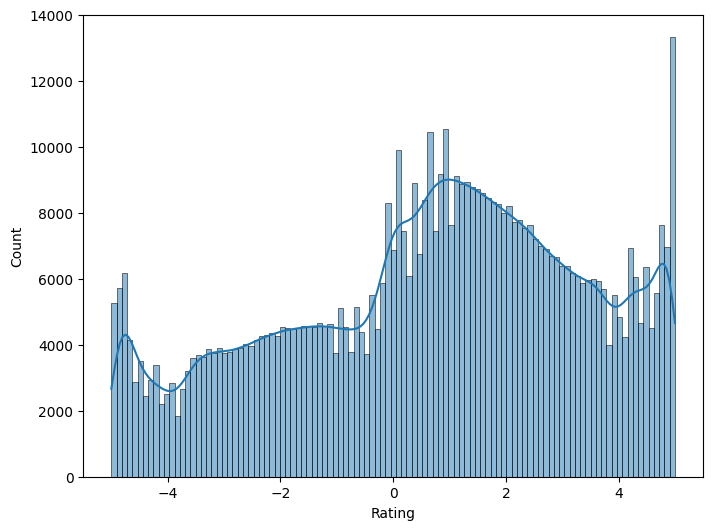

In [10]:
#check out the Rating distribution
plt.figure(figsize=(8,6))
sns.histplot(train_df['Rating'],kde=True)
plt.show()

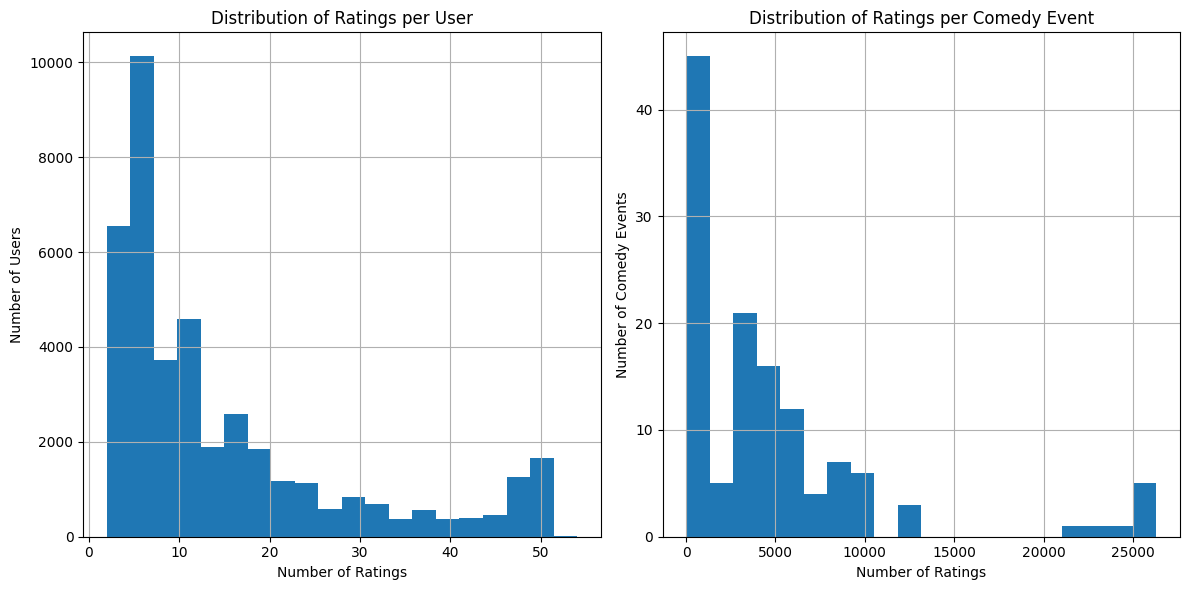

(count    40863.000000
 mean        14.994053
 std         13.251594
 min          2.000000
 25%          6.000000
 50%         10.000000
 75%         19.000000
 max         54.000000
 Name: Rating, dtype: float64,
 count      127.000000
 mean      4824.425197
 std       6200.496560
 min          1.000000
 25%        197.500000
 50%       3319.000000
 75%       5924.500000
 max      26311.000000
 Name: Rating, dtype: float64)

In [11]:
user_ratings_count = train_df.groupby('Viewers_ID')['Rating'].count()
event_ratings_count = train_df.groupby('Joke_identifier')['Rating'].count()

user_ratings_count_desc = user_ratings_count.describe()
event_ratings_count_desc = event_ratings_count.describe()

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
user_ratings_count.hist(bins=20)
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')

plt.subplot(1, 2, 2)
event_ratings_count.hist(bins=20)
plt.title('Distribution of Ratings per Comedy Event')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Comedy Events')

plt.tight_layout()
plt.show()

user_ratings_count_desc, event_ratings_count_desc

In [13]:
# Determine the number of rating each event has and its average rating
df_event_grp = train_df.groupby('Joke_identifier').agg(Number_of_Rating=('Rating', 'count'),
    Mean_Rating=('Rating', 'mean')).sort_values('Number_of_Rating', ascending=False)
df_event_grp.head()

,Number_of_Rating,Mean_Rating
Joke_identifier,,
Klint De Drunk PH 2,26311,-0.710283
Klint De Drunk Enugu 2,26286,-0.969887
Klint De Drunk PH 1,26254,-0.300439
Klint De Drunk Enugu 3,26234,-0.337520
Klint De Drunk Lagos 1,25864,-0.800931


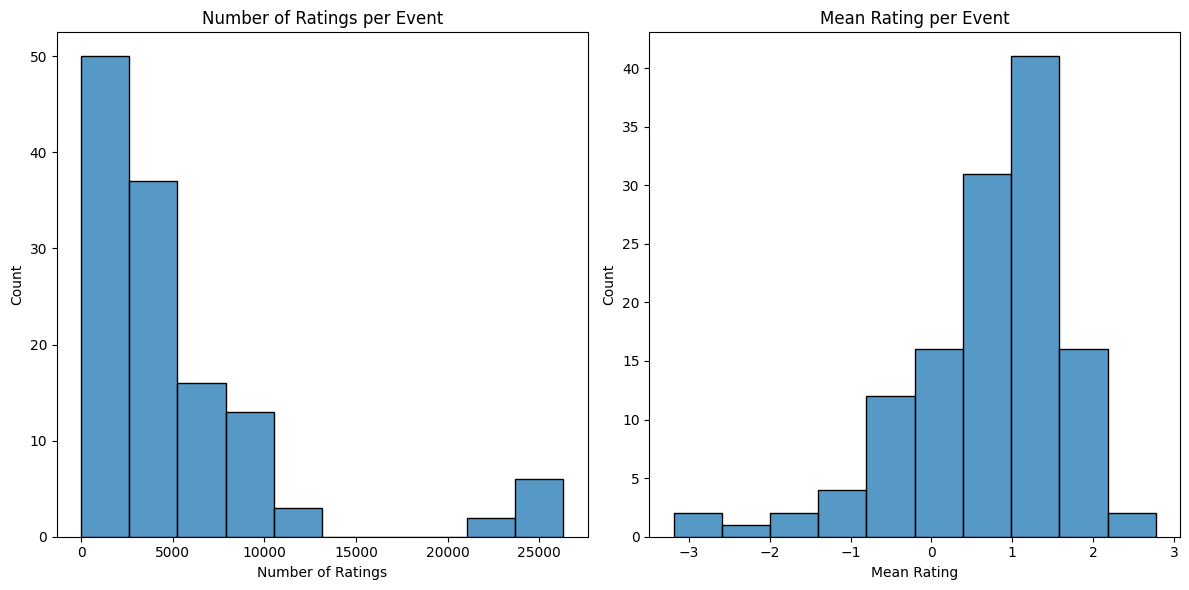

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_event_grp['Number_of_Rating'], bins=10, kde=False)
plt.title('Number of Ratings per Event')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(df_event_grp['Mean_Rating'], bins=10, kde=False)
plt.title('Mean Rating per Event')
plt.xlabel('Mean Rating')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# **Recommendation Based on Popularity**

In [15]:
# calculate the mean ratings across all events
mean_rating = train_df['Rating'].mean()
mean_rating

0.6470239855590485

In [16]:
# rate count of each event
rating_count = pd.DataFrame(train_df.groupby('Joke_identifier')['Rating'].count().sort_values(ascending=False))
rating_count.head()

,Rating
Joke_identifier,
Klint De Drunk PH 2,26311
Klint De Drunk Enugu 2,26286
Klint De Drunk PH 1,26254
Klint De Drunk Enugu 3,26234
Klint De Drunk Lagos 1,25864


In [17]:
# determine the minimum number of ratings needed to make the charts (popularity)
min_rating = rating_count['Rating'].quantile(0.9)
min_rating

9691.000000000002

In [18]:
q_events = rating_count[rating_count['Rating'] > min_rating].reset_index()
q_events.head()

,Joke_identifier,Rating
0,Klint De Drunk PH 2,26311
1,Klint De Drunk Enugu 2,26286
2,Klint De Drunk PH 1,26254
3,Klint De Drunk Enugu 3,26234
4,Klint De Drunk Lagos 1,25864


In [34]:
#q_events = q_events.to_csv('/kaggle/working/q_events.csv', index=False)

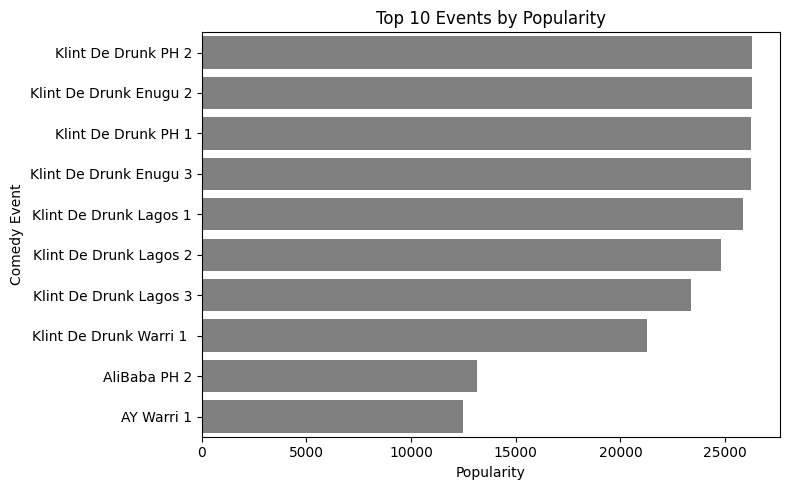

In [19]:
# Filter for the top 10 events based on scores
popular_10_events = q_events.head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=popular_10_events['Rating'], y=popular_10_events['Joke_identifier'], color="grey")
#plt.xticks(rotation=0)
plt.title('Top 10 Events by Popularity')
plt.xlabel('Popularity')
plt.ylabel('Comedy Event')

plt.tight_layout()
plt.show()

# **Collaborative Filtering**

In [20]:
#Lets see the number of times each events got rated by viewers
event_rating_count = pd.DataFrame(train_df.groupby('Joke_identifier')['Rating'].count().sort_values(ascending=False))
event_rating_count.head()

,Rating
Joke_identifier,
Klint De Drunk PH 2,26311
Klint De Drunk Enugu 2,26286
Klint De Drunk PH 1,26254
Klint De Drunk Enugu 3,26234
Klint De Drunk Lagos 1,25864


In [21]:
# The number of events each viewer rated
viewer_rating_count = pd.DataFrame(train_df.groupby('Viewers_ID')['Rating'].count().sort_values(ascending=False))
viewer_rating_count.head()

,Rating
Viewers_ID,
A366,54
A233,54
A367,54
A179,54
A337,54


In [22]:
#select events that have only been rated 11 times or more
popular_events = event_rating_count[event_rating_count['Rating'] >= 11].index
filtered_popular_events = train_df[train_df['Joke_identifier'].isin(popular_events)]
filtered_popular_events.head()

,Viewers_ID,Joke_identifier,Response_ID,Rating
0,A1,Klint De Drunk Enugu 1,A1_Klint De Drunk Enugu 1,0.11
1,A1,Klint De Drunk Enugu 2,A1_Klint De Drunk Enugu 2,-4.64
2,A1,Klint De Drunk PH 1,A1_Klint De Drunk PH 1,-3.39
3,A1,Klint De Drunk PH 2,A1_Klint De Drunk PH 2,0.44
4,A1,Klint De Drunk Lagos 1,A1_Klint De Drunk Lagos 1,-4.83


In [23]:
# select viewers who rated 6 times or more
viewers_count = viewer_rating_count[viewer_rating_count['Rating'] >= 6].index
filtered_popular_events = filtered_popular_events[filtered_popular_events['Viewers_ID'].isin(viewers_count)]
filtered_popular_events.head()

,Viewers_ID,Joke_identifier,Response_ID,Rating
0,A1,Klint De Drunk Enugu 1,A1_Klint De Drunk Enugu 1,0.11
1,A1,Klint De Drunk Enugu 2,A1_Klint De Drunk Enugu 2,-4.64
2,A1,Klint De Drunk PH 1,A1_Klint De Drunk PH 1,-3.39
3,A1,Klint De Drunk PH 2,A1_Klint De Drunk PH 2,0.44
4,A1,Klint De Drunk Lagos 1,A1_Klint De Drunk Lagos 1,-4.83


In [39]:
#filtered_popular_events = filtered_popular_events.to_csv('/kaggle/working/filtered_popular_events.csv', index=False)

In [24]:
print('Original Dataframe shape :', train_df.shape, end='\n\n')
print('Filtered Dataframe shape :', filtered_popular_events.shape)

Original Dataframe shape : (612702, 4)

Filtered Dataframe shape : (572786, 4)


In [30]:
reader = Reader(rating_scale=(-5,5))
train_data = Dataset.load_from_df(filtered_popular_events[['Viewers_ID','Joke_identifier','Rating']], reader)

results_benchmarking = []
algorithms = [SVD(), NMF(), KNNWithMeans(), SVDpp(), BaselineOnly(), KNNBasic()]

for test_algo in algorithms:
    results = cross_validate(test_algo, train_data, measures=['RMSE', 'MAE'], cv=3, verbose=True)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    split_data = pd.Series([str(test_algo).split(' ')[0].split('.')[-1]], index=['Algorithm'])
    tmp = pd.concat([tmp, split_data])
    results_benchmarking.append(tmp)
    
# Convert the list of results to a DataFrame for better visualization
results_df = pd.DataFrame(results_benchmarking)

results_df


Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.1223  2.1204  2.1222  2.1216  0.0008  
MAE (testset)     1.6332  1.6316  1.6331  1.6326  0.0007  
Fit time          5.61    5.60    5.58    5.59    0.01    
Test time         2.34    1.88    2.22    2.14    0.19    
Evaluating RMSE, MAE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    3.7202  3.3895  2.8150  3.3082  0.3740  
MAE (testset)     2.9274  2.6445  2.3567  2.6429  0.2330  
Fit time          11.16   11.32   11.53   11.33   0.15    
Test time         1.71    1.71    1.81    1.75    0.05    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fo

,test_rmse,test_mae,fit_time,test_time,Algorithm
0,2.121618,1.632650,5.594726,2.143308,SVD
1,3.308227,2.642867,11.333523,1.745873,NMF
2,2.137090,1.637100,191.107160,1179.074015,KNNWithMeans
3,2.315141,1.724432,30.972528,9.431653,SVDpp
4,2.171432,1.733196,1.610418,1.856203,BaselineOnly
5,2.235896,1.756642,214.478592,1189.791218,KNNBasic


In [85]:
#reader = Reader(rating_scale=(-5,5))
#train_data = Dataset.load_from_df(filtered_popular_events[['Viewers_ID','Joke_identifier','Rating']], reader)

#param_dist = {
   # 'n_factors': np.arange(20, 40, 5),
    #'n_epochs': np.arange(20, 40, 5),
    #'lr_all': np.arange(0.002,0.1, 0.02),
    #'reg_all': np.arange(0.008,0.1,0.02)
#}

#rs = RandomizedSearchCV(SVD, param_dist, measures=['rmse'], cv=5)

#rs.fit(train_data)

# Get the best score and the best parameters
#print("Best RMSE score obtained: ", rs.best_score['rmse'])
#print("Best parameters: ", rs.best_params['rmse'])'''

In [25]:
reader = Reader(rating_scale=(-5,5))
train_data = Dataset.load_from_df(filtered_popular_events[['Viewers_ID','Joke_identifier','Rating']], reader)
kf = KFold(n_splits = 5,random_state=42)
svd = SVD(n_factors=35, n_epochs=35, lr_all = 0.0022,reg_all=0.083, random_state=42)
#cross validation

rmse_values = []
for trainset, testset in kf.split(train_data):
    svd.fit(trainset)
    predictions = svd.test(testset)
    error = accuracy.rmse(predictions, verbose=True)
    rmse_values.append(error)

mean_rmse = sum(rmse_values) / len(rmse_values)
print(f"Mean RMSE: {mean_rmse:.4f}")

RMSE: 2.0810
RMSE: 2.0858
RMSE: 2.0849
RMSE: 2.0780
RMSE: 2.0969
Mean RMSE: 2.0853


In [26]:
#Train on full dataset
full_trainset = train_data.build_full_trainset()
svd_model = svd.fit(full_trainset)

In [27]:
# Save the model
#joblib.dump(svd_model, 'svd_model.pkl')

In [28]:
# Compute event similarity scores
item_factors = svd_model.qi
# Calculate cosine similarity between event feature vectors
item_similarity = cosine_similarity(item_factors)
# Convert the similarity matrix to a DataFrame for better readability
item_ids = full_trainset.all_items()
item_id_map = {inner_id: raw_id for raw_id, inner_id in full_trainset._raw2inner_id_items.items()}
item_labels = [item_id_map[item_id] for item_id in item_ids]
item_similarity_df = pd.DataFrame(item_similarity, index=item_labels, columns=item_labels)

In [29]:
item_similarity_df.head()

,Klint De Drunk Enugu 1,Klint De Drunk Enugu 2,Klint De Drunk PH 1,Klint De Drunk PH 2,Klint De Drunk Lagos 1,Klint De Drunk Lagos 2,Klint De Drunk Lagos 3,Klint De Drunk Warri 1,AliBaba Lagos 2,AliBaba Aso Rock 2,...,Helen Paul Abuja 3,BasketMouth Owerri 1,Helen Paul Lagos 3,Helen Paul Abuja 2,Helen Paul Lagos 2,Helen Paul Lagos 1,Akpororo Abuja 5,AY Abuja 2,Saka Lagos 2,Saka Ibadan 3
Klint De Drunk Enugu 1,1.000000,0.017655,0.294502,0.431747,0.059786,0.005708,-0.093820,-0.091356,-0.009598,-0.235830,...,-0.149172,0.082591,-0.008318,-0.407007,-0.009647,-0.099813,-0.056516,0.044574,0.009581,-0.082938
Klint De Drunk Enugu 2,0.017655,1.000000,0.367067,0.428005,0.187270,0.070134,0.141221,0.018532,-0.092331,-0.151125,...,-0.255861,-0.078920,-0.194720,-0.063768,-0.146614,-0.107167,-0.217747,0.047458,-0.060452,-0.392759
Klint De Drunk PH 1,0.294502,0.367067,1.000000,0.570554,0.222534,0.051692,0.159937,-0.086093,0.222978,-0.183284,...,-0.350153,-0.017062,-0.181643,-0.188134,0.063656,-0.055612,-0.024292,0.240711,-0.028707,-0.431674
Klint De Drunk PH 2,0.431747,0.428005,0.570554,1.000000,0.433190,0.096810,0.344959,0.120602,-0.042092,-0.133816,...,-0.043214,0.055796,-0.188628,-0.136931,-0.057532,-0.116968,-0.250183,0.067155,0.026584,-0.432112
Klint De Drunk Lagos 1,0.059786,0.187270,0.222534,0.433190,1.000000,0.172939,0.606145,0.165902,0.009752,-0.142654,...,-0.320289,0.111578,-0.058425,-0.120638,0.072547,-0.134716,-0.175261,0.040653,-0.046808,-0.385422


In [30]:
# The idea here is to make recommendations based on the predicted ratings and similarity score of the items(comedy_events)
# some events may have very high ratings but are rated just a few times. The similarity scores for these events and one
# that was rated high too but multiple times will have the same similarity score.
# So adjust the similarity scores based on some weights. The former will have less weight than the later

item_factors = svd_model.qi 

# Calculate cosine similarity between event feature vectors
item_similarity = cosine_similarity(item_factors)

# Compute rating counts for events
item_counts = train_df['Joke_identifier'].value_counts()
item_ids = full_trainset.all_items()

# Create a mapping from event ids to indices in the item_factors matrix
item_id_map = {inner_id: raw_id for raw_id, inner_id in full_trainset._raw2inner_id_items.items()}
item_id_map_inv = {raw_id: inner_id for inner_id, raw_id in item_id_map.items()}

# Get the event counts and normalize them
item_counts = np.array([item_counts.get(item_id_map[inner_id], 0) for inner_id in item_ids])
normalized_counts = item_counts / np.max(item_counts)

# Compute weights inversely proportional to the number of ratings
# Avoid division by zero
weights = 1 / (item_counts + 1)  

# Adjust the similarity scores based on the weights
# use broadcasting to apply weights to each entry in the similarity matrix
weighted_similarity = item_similarity * np.outer(weights, weights)

# Normalize the weighted similarity matrix
weighted_similarity_normalized = normalize(weighted_similarity, axis=1, norm='l1')

# Convert the similarity matrix to a DataFrame
item_labels = [item_id_map[inner_id] for inner_id in item_ids]
item_similarity_df = pd.DataFrame(weighted_similarity_normalized, index=item_labels, columns=item_labels)

# Save the similarity matrix
#item_similarity_df.to_pickle('item_similarity_df.pkl')

In [31]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435873 entries, 0 to 435872
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Viewers_ID       435873 non-null  object
 1   Joke_identifier  435873 non-null  object
 2   Response_ID      435873 non-null  object
dtypes: object(3)
memory usage: 10.0+ MB


In [32]:
#Make Predictions
test_df['Rating'] = test_df.apply(lambda x: svd_model.predict(x['Viewers_ID'], x['Joke_identifier']).est, axis=1)
test_df.head()

,Viewers_ID,Joke_identifier,Response_ID,Rating
0,A1,Akpororo Lagos 1,A1_Akpororo Lagos 1,2.845991
1,A1,Akpororo Abuja 1,A1_Akpororo Abuja 1,2.720005
2,A1,Akpororo Abuja 5,A1_Akpororo Abuja 5,1.701232
3,A1,I Go Dye Benin 1,A1_I Go Dye Benin 1,2.952259
4,A1,I Go Dye Benin 3,A1_I Go Dye Benin 3,1.274754


In [29]:
#predicted_ratings = test_df.copy()
#predicted_ratings.to_csv('/kaggle/working/predicted_ratings.csv', index=False)

In [33]:
output = pd.DataFrame({'Response_ID': test_df['Response_ID'], 'Rating': test_df['Rating']})
output.head(15)

,Response_ID,Rating
0,A1_Akpororo Lagos 1,2.845991
1,A1_Akpororo Abuja 1,2.720005
2,A1_Akpororo Abuja 5,1.701232
3,A1_I Go Dye Benin 1,2.952259
4,A1_I Go Dye Benin 3,1.274754
5,A1_I Go Dye Uyo 1,1.615830
6,A1_I Go Dye Uyo 2,2.251223
7,A1_Seyi Law Abuja 3,-0.517401
8,A1_Seyi Law Abuja 4,-0.610167
9,A1_Gordons Lagos 2,2.889728


In [34]:
#output.to_csv('/kaggle/working/ratings.csv', index=False)

In [35]:
# Get recommendations
# For a particular viewer, check the events which they rated 3 or higher and recommend events(not yet seenby the viewer) similar to them.
def recommend_top_events(viewer_id, filtered_train_df, test_df, item_similarity_df, top_10_df, top_n=10):
    
    def format_top_events(top_10_df, top_n):
        top_events = top_10_df.head(top_n)['Joke_identifier'].tolist()
        formatted_events = "\n".join([f"{i+1}. {event}" for i, event in enumerate(top_events)])
        return formatted_events
    
    # Filter the train_df for the specified user and find highly rated events
    viewer_ratings = filtered_popular_events[filtered_popular_events['Viewers_ID'] == viewer_id]
    highly_rated_events = viewer_ratings[viewer_ratings['Rating'] >= 3]['Joke_identifier'] 
    
    if viewer_ratings.empty:
        return format_top_events(top_10_df, top_n)
    
    if highly_rated_events.empty:
        return format_top_events(top_10_df, top_n)
    
    # Initialize a dictionary to store the scores for recommendations
    scores = {}
    
    # Iterate over the highly rated events
    for event_id in highly_rated_events:
        if event_id in item_similarity_df.index:
            # Get similar events and their similarity scores
            similar_items = item_similarity_df.loc[event_id]
            
            for sim_item_id, similarity in similar_items.items():
                # Get the predicted rating for the similar event from test_df
                predicted_rating = test_df[(test_df['Viewers_ID'] == viewer_id) & (test_df['Joke_identifier'] == sim_item_id)]['Rating'].values
                if len(predicted_rating) > 0:
                    predicted_rating = predicted_rating[0]
                    if sim_item_id not in scores:
                        scores[sim_item_id] = 0
                    # Combine the similarity score and the predicted rating
                    scores[sim_item_id] += similarity * predicted_rating
                    
    if not scores:
        return format_top_events(top_10_df, top_n)
    
    # Sort items by their aggregated scores in descending order
    recommended_item_ids = sorted(scores, key=scores.get, reverse=True)[:top_n]
    
    # Create a numbered string of the top 10 event_ids
    recommended_items = "\n".join([f"{i+1}. {item_id}" for i, item_id in enumerate(recommended_item_ids)])
    
    return recommended_items

In [36]:
viewer_id = 'A1000' 
top_10_events = recommend_top_events(viewer_id, filtered_popular_events, test_df, item_similarity_df, q_events)
print(top_10_events)

1. Saka Lagos 3
2. Helen Paul Abuja 3
3. Saka Ibadan 3
4. Seyi Law Abuja 2
5. Seyi Law Abuja 3
6. Gordons Abuja 1
7. I Go Dye Benin 2
8. I Go Dye Uyo 2
9. Seyi Law Ibadan 1
10. Seyi Law Ibadan 3


Cold Start Problem: This approach relies on past ratings. For new viewers with no rating history, providing recommendations might be challenging. Hybrid methods combining content-based filtering or using demographic information could address this.